In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [3]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

# Import constants

In [4]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids
from rgc_natstim_model.constants.paths import base_directory
print(base_directory)

/mnt/lustre/work/bethge/bkr578/data/rgc-natstim


# Set device

In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

# Assemble paths

In [6]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-07-20_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-07-20_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

model_type = 'nonlinear'

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

## plot settings

In [7]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2,2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
                       'lines.markeredgewidth': .1,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

# Loading

### movies

In [8]:
# load the movie 
fpath = '/'.join([base_directory, 'data', 'movie', movie_file_name])
print(fpath)
movies_dict = pickle.load(open(fpath, "rb"))

# load the movie file with the pre-flip-correction movie
movies_dict_flip = pickle.load(open('/'.join([base_directory, 'data', 'movie', flipped_movie_file_name]), "rb"))

/mnt/lustre/work/bethge/bkr578/data/rgc-natstim/data/movie/2024-01-11_movies_dict_c285329.pkl


In [9]:
base_directory



'/mnt/lustre/work/bethge/bkr578/data/rgc-natstim'

### load all datasets

In [10]:
movie_data_dicts = {}
dataloaders_dict = {}
for dh, dfn in zip(dataset_hashes, data_file_names):
    data_path = os.path.join(base_directory, "data", 'base',dfn)
    responses = load_h5_into_dict(data_path)
    _movie_data_dict = make_final_responses(responses, response_type="natural") # upsampling
    if dh == '5e620609fc7b491aa5edb4a5d4cd7276':
        _dataloaders = natmov_dataloaders_v2(
        _movie_data_dict, movies_dict_flip, seed=1000
    )
    else:
        _dataloaders = natmov_dataloaders_v2(
            _movie_data_dict, movies_dict, seed=1000
        )
    movie_data_dicts.update({dh:_movie_data_dict})
    dataloaders_dict.update({dh:_dataloaders})

Loading HDF5 file contents: 100%|██████████| 385/385 [00:00<00:00, 976.93item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 11/11 [00:00<00:00, 39.79it/s]
Loading HDF5 file contents: 100%|██████████| 175/175 [00:00<00:00, 1139.95item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 5/5 [00:00<00:00, 43.11it/s]
Loading HDF5 file contents: 100%|██████████| 140/140 [00:00<00:00, 1223.27item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 4/4 [00:00<00:00, 41.70it/s]
Loading HDF5 file contents: 100%|██████████| 700/700 [00:00<00:00, 1130.89item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 20/20 [00:00<00:00, 33.60it/s]
Loading HDF5 file contents: 100%|██████████| 210/210 [00:00<00:00, 1157.54item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 6/6 [00:00<00:00, 40.51it/s]
Loading HDF5 file contents: 100%|██████████| 945/945 [00:00<00:00, 1089.63item/s]
Upsampling natural t

In [11]:
# ToDo 
dh_2_session_ids = {k: list(v.keys()) for k, v in movie_data_dicts.items()}
session_ids_2_dhs = {_v: k for k, v in movie_data_dicts.items() for _v in list(v.keys())}
# remove empty session
session_ids_2_dhs.pop('session_1_ventral2_20200701')
dh_2_session_ids['5e620609fc7b491aa5edb4a5d4cd7276'].remove('session_1_ventral2_20200701')

dh_2_session_ids_renamed = {dh: ['_'.join(el.split('_')[1:]) for el in v] for dh, v in dh_2_session_ids.items()}

# Collect data in dataframe

In [12]:
df = convert_nested_dict_to_dataframe(movie_data_dicts)

# Predict test responses

### load model

In [13]:
def get_test_stim(dataloaders_dict, dataset_hash, session_id):
    return torch.unsqueeze(
        dataloaders_dict[dataset_hash]['test'][session_id].dataset.movies, 0
    ).cuda()


## CNN type model

In [14]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh[dataset_hash]
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path, device=DEVICE);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim,  
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/openretina/hoefling_2024/nnfabrik_model_loading.py:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

Random seed 0 has been set.


/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/openretina/hoefling_2024/models.py:854: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return mask.T


Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ig

In [15]:
df.insert(df.shape[1], 'corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

## LN type model

In [17]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
model_type = 'linear'
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh_linear[dataset_hash]
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path, device=DEVICE);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim, 
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Rando

In [18]:
df.insert(df.shape[1], 'lin_corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'lin_single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'lin_test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

# Insert additional columns to DF

In [19]:
df['movie_qis_recalc'] = df.apply(lambda x: calculate_nat_reliability_index(x), axis=1)

In [20]:
df['max_conf'] = df.apply(lambda row: row['group_confidences'][row['group_assignment']-1], axis=1)

In [21]:
df['single_trial_corr_avg'] = df.apply(
    lambda x: x['single_trial_corr'].mean(),
    axis=1
)

In [ ]:
#with open(os.path.join(base_directory, 'data', 'full_data_df.pkl'), 'wb') as f:
#    df.to_pickle(f)

# filter DF

In [22]:
restr_df = df[(df['max_conf']>=.25) & (df['group_assignment']<33)]

In [23]:
restr_df[restr_df['single_trial_corr_avg']>.3].shape

(1947, 55)

In [24]:
restr_df[restr_df['single_trial_corr_recalc']>.3].shape

(1947, 55)

In [ ]:

#with open(os.path.join(base_directory, 'data', 'restr_data_df.pkl'), 'wb') as f:
#    restr_df.to_pickle(f)

# plot predictions for example cells

## define hashes for example session

In [25]:
dataset_hash_current = '57ff42f31240ab511be30f98b4a07ffe'

ensemble_hash_current = dh2eh[dataset_hash_current]
print(ensemble_hash_current)

session_id_current = '2_ventral2_20201117'
neuron_id_current = '20201117_2_2_66_s_5'
print(session_id_current)

9d574ab9fcb85e8251639080c8d402b7
2_ventral2_20201117


Text(0.5, 1.02, 'Test movie responses\n and predictions')

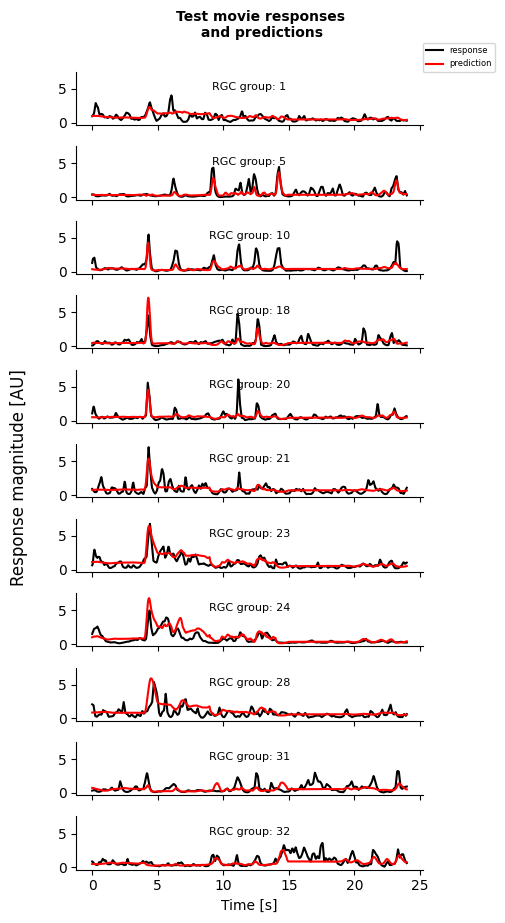

In [26]:
dataloaders_dict[dataset_hash_current]['test'][f'session_{session_id_current}'].dataset.responses
max_t = 720/30
time_axis = np.linspace(0, max_t, 720)
fig, axes = plt.subplots(len(example_nids), 1, figsize=(5, 9), sharex=True, sharey=True)
for i, (ax, (celltype, neuron_id)) in enumerate(zip(axes.ravel(), example_nids.items())):
    ax.plot(time_axis, df['test_response'].loc[neuron_id].mean(axis=0), color='k', label='response')
    ax.plot(time_axis, df['test_prediction_recalc'].loc[neuron_id], color='r', label='prediction')
    ax.set_title(f'RGC group: {celltype}', fontsize=8, y=.5)

axes[0].legend(fontsize=6, loc=(1,1))
ax.set_xlabel('Time [s]')
fig.supylabel('Response magnitude [AU]', x=0)
sns.despine()
plt.tight_layout()
plt.suptitle('Test movie responses\n and predictions', y=1.02, fontsize=10, fontweight='bold')

# plot corrs

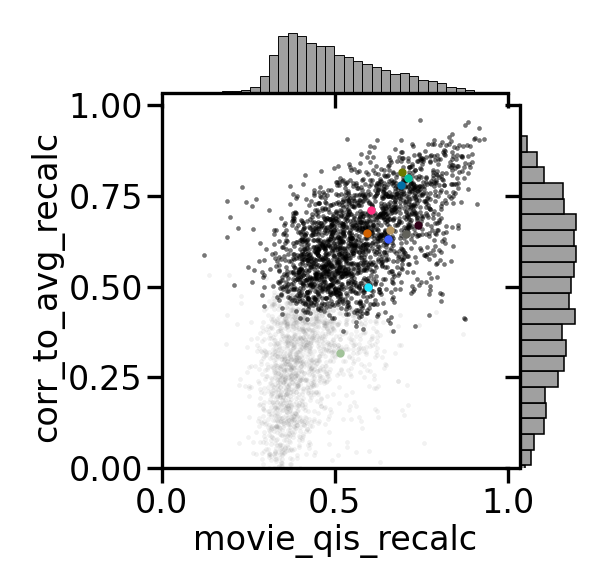

In [27]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="movie_qis_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[0., 1], ylim=[0, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], x="movie_qis_recalc", y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    for t, nid in example_nids.items():
        g.ax_joint.scatter(restr_df["movie_qis_recalc"].loc[nid], 
                           restr_df["corr_to_avg_recalc"].loc[nid],
                           color=rgc_colors[t-1],
                           
                           
                           )

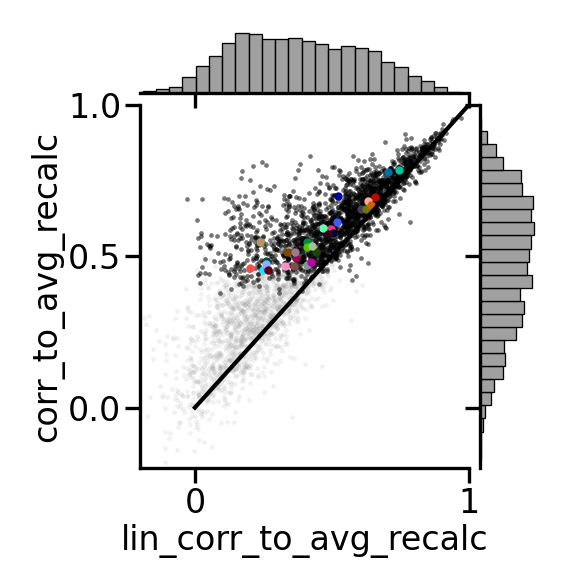

In [28]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="lin_corr_to_avg_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[-.2, 1], ylim=[-.2, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], 
                    x="lin_corr_to_avg_recalc", 
                    y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    g.ax_joint.plot([0,1], [0,1], color='k', linewidth=1)
    for t in range(1, 33):
        temp_df = restr_df[(restr_df['group_assignment']==t) & (restr_df["corr_to_avg_recalc"]>.3)]
        g.ax_joint.scatter(temp_df["lin_corr_to_avg_recalc"].mean(), 
                           temp_df["corr_to_avg_recalc"].mean(),
                           color=rgc_colors[t-1],#edgecolor="k"
                           )
